In [15]:
#conflict
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import pandas as pd
from pandas import DataFrame as df
from mpld3 import plugins, fig_to_html, save_html, fig_to_dict
from tqdm import tqdm
import numpy as np
import json
from tensorflow.keras.preprocessing.text import text_to_word_sequence
#character, setting
import numpy as np
import gensim
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from nltk.tokenize import sent_tokenize
import multiprocessing
import os
from pathlib import Path
import io
from gensim.models import Phrases
from textblob import TextBlob
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models, similarities

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kimkwangil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kimkwangil/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
#human을 의미하는 단어가 문장 전체에 포함 비율

from enum import Enum


class ContainsBio(Enum):
    YES = 1
    NO = 0
    MAYBE = 2


def human_contains_pronouns(bio):
    perfect_matches = ['he/him', 'she/her', 'they/them', 'ze', 'hir']
    probably_matches = ['they', 'he', 'her', 'him', 'her', 'pronouns']

    words = re.findall(r"[\w'/]+", bio.lower())
    for match in perfect_matches:
        if match in words:
            return ContainsBio.YES

    for match in probably_matches:
        if match in words:
            return ContainsBio.MAYBE
    return ContainsBio.NO

In [17]:
input_text= """A window into the soul.For most people, this would be the eyes. The eyes cannot lie; they often tell more about a person's emotions than their words. What distinguishes a fake smile from a genuine one? The eyes. What shows sadness? The eyes. What gives away a liar? The eyes.But are the eyes the only window into the soul?Recently, I began painting with watercolors. With watercolors, there is no turning back: if one section is too dark, it is nearly impossible to lighten the area again. Every stroke must be done purposefully, every color mixed to its exact value.I laid my materials before me, preparing myself for the worst. I checked my list of supplies, making sure my setup was perfect.I wet my brush, dipped it into some yellow ochre, and dabbed off the excess paint. Too little water on my brush. I dipped my brush back into my trusty water jar; the colors swirled beautifully, forming an abstract art piece before my eyes. \u2014It's a shame that I couldn't appreciate it.I continued mixing colors to their exact value. More alizarin crimson. More water. More yellow ochre. Less water. More phthalo blue. The cycle continued. Eventually, I was satisfied. The colors looked good, there was enough contrast between facial features, and the watercolors stayed inside the lines.Craving feedback, I posted my art to Snapchat. I got a few messages such as 'wow' and 'pretty,' but one message stood out. 'You were anxious with this one, huh? Anyways, love the hair!'I was caught off guard. Was it a lucky guess? Did they know something I didn't? I immediately responded: 'Haha, how could you tell?' No response.What I didn't know at the time was that my response would come a few months later while babysitting. Since the girl I was babysitting loved art, I took out some Crayola watercolors and some watercolor paper for her to play with. After I went to the bathroom and came back, the watercolors were doused with water. 'You were impatient with this one, huh? Anyways, love the little dog you drew!'The little girl looked up at me, confused. 'How could you tell?' 'You used a lot of water for a brighter color, but you couldn't wait for it to slowly soak in.''Oh.'Now, I would be lying if I said I realized the connection between the two events immediately.Instead, I made the connection when I decided to sit down one day and objectively critique my art. The piece that I once loved now seemed like a nervous wreck: the paper was overworked, the brushstrokes were undecided, the facial features blended together, and each drop of water was bound inside the lines as if it was a prisoner in a cage.From then on, I started noticing pieces of personality in additional creations surrounding me: website designs, solutions to math problems, code written for class, and even the preparation of a meal.When I peer around at people's projects during Code Club, I notice the clear differences between their code. Some people break it up by commenting in every possible section. Others breeze through the project, not caring to comment or organize their code. I could also see clear differences in personalities when our club members began coding the Arduino for the first time. Some followed the tutorials to the letter, while others immediately started experimenting with different colored LEDs and ways of wiring the circuit.It became clear to me that, as humans, we leave pieces of our souls in everything we do, more than we intend to. If we entertain this thought, perhaps the key to better understanding others around us is simply noticing the subtler clues under our noses?Perhaps there are endless windows to the soul, and we simply need to peer through them. I shakily rose my hand. 'We should create workshops of our own,' I suggested.I got a few strange looks. 'It's a good idea, but it's too much work.' 'We just don't have enough free time to make it work.' 'Maybe we could, but I don't know how to make workshops.' My suggestion was shot down. I shuffled in my seat. 'I could make them.' A few people stared at me in disbelief. I glanced over at the club advisor, Mr. C, nervous to hear his response.'If you're willing to take on the work, we can try it.' Mr. C replied. And so I embarked on my quest. I researched different workshops on the internet, learning the information myself at first. Then, I transitioned into creating workshops of my own, making sure that the information was easy to understand for even a beginner. I was exhausted; my first workshop took 16 cumulative hours to create."""

In [18]:
humnan_pronoun = human_contains_pronouns(input_text)
humnan_pronoun

<ContainsBio.MAYBE: 2>

In [19]:
def academic_words_ratio(text):

    essay_input_corpus = str(text) #문장입력
    essay_input_corpus = essay_input_corpus.lower()#소문자 변환

    sentences  = sent_tokenize(essay_input_corpus) #문장 토큰화
    total_sentences = len(sentences)#토큰으로 처리된 총 문장 수
    total_words = len(word_tokenize(essay_input_corpus))# 총 단어수
    
    split_sentences = []
    for sentence in sentences:
        processed = re.sub("[^a-zA-Z]"," ", sentence)
        words = processed.split()
        split_sentences.append(words)

    skip_gram = 1
    workers = multiprocessing.cpu_count()
    bigram_transformer = Phrases(split_sentences)

    model = gensim.models.word2vec.Word2Vec(bigram_transformer[split_sentences], workers=workers, sg=skip_gram, min_count=1)

    model.train(split_sentences, total_examples=sum([len(sentence) for sentence in sentences]), epochs=100)
    
    #모델 설계 완료

    #OVERLAP 단어들을 리스트에 넣어서 필터로 만들고
    character_list = ['Arts','abandon','abstract','academy','access',  'accommodate','accompany','accumulate',
                      'accurate','achieve',  'acknowledge','acquire','adapt','adequate','adjacent','adjust',
                      'administration',  'adult','advocate','affect','aggregate','aid','albeit','allocate','alter',
                      'alternative','ambiguous','amend','analogy','analyse','annual','anticipate','apparent','append',
                      'appreciate',  'approach','appropriate','approximate','arbitrary','area','aspect','assemble',
                      'assess','assign','assist','assume','assure','attach','attain','attitude',  'attribute',
                      'author','authority','automate','available','aware','behalf','benefit','bias','bond','brief',
                      'bulk','capable','capacity','category','cease','challenge','channel','chapter',  'chart',
                      'chemical','circumstance','cite','civil','clarify','classic','clause','code','coherent',
                      'coincide','collapse','colleague','commence','comment','commission','commit','commodity',
                      'communicate','community','compatible','compensate','compile','complement',  'complex',
                      'component','compound','comprehensive','comprise','compute','conceive',  'concentrate',
                      'concept','conclude','concurrent','conduct','confer','confine',  'confirm',  'conflict',
                      'conform','consent','consequent','considerable','consist','constant','constitute','constrain',
                      'construct','consult','consume','contact','contemporary','context','contract','contradict',
                      'contrary',  'contrast',  'contribute',  'controversy',  'convene',  'converse',  'convert',  
                      'convince',  'cooperate',  'coordinate',  'core',  'corporate',  'correspond',  'couple',  
                      'create',  'credit',  'criteria',  'crucial',  'culture',  'currency',  'cycle',  'data',  
                      'debate',  'decade',  'decline',  'deduce',  'define',  'definite',  'demonstrate',  'denote', 
                      'deny',  'depress',  'derive',  'design',  'despite',  'detect',  'deviate',  'device',  
                      'devote',  'differentiate',  'dimension',  'diminish',  'discrete',  'discriminate','displace',
                      'display',  'dispose',  'distinct',  'distort',  'distribute',  'diverse',  'document',  
                      'domain',  'domestic',  'dominate',  'draft',  'drama',  'duration',  'dynamic',  'economy',
                      'edit',  'element',  'eliminate',  'emerge',  'emphasis',  'empirical',  'enable',  'encounter',
                      'energy',  'enforce',  'enhance',  'enormous',  'ensure',  'entity',  'environment',  'equate',
                      'equip',  'equivalent',  'erode',  'error',  'establish',  'estate',  'estimate',  'ethic',
                      'ethnic',  'evaluate',  'eventual',  'evident',  'evolve',  'exceed',  'exclude',  'exhibit',  
                      'expand',  'expert',  'explicit',  'exploit',  'export',  'expose',  'external',  'extract',  
                      'facilitate',  'factor',  'feature',  'federal',  'fee',  'file',  'final',  'finance',  
                      'finite',  'flexible',  'fluctuate',  'focus',  'format',  'formula',  'forthcoming',  
                      'foundation',  'found',  'framework',  'function',  'fund',  'fundamental',  'furthermore',  
                      'gender',  'generate',  'generation',  'globe',  'goal',  'grade',  'grant',  'guarantee',  
                      'guideline',  'hence',  'hierarchy',  'highlight',  'hypothesis',  'identical',  'identify',  
                      'ideology',  'ignorance',  'illustrate',  'image',  'immigrate',  'impact',  'implement',  
                      'implicate',  'implicit',  'imply',  'impose',  'incentive',  'incidence',  'incline',  
                      'income',  'incorporate',  'index',  'indicate',  'individual',  'induce',  'inevitable', 
                      'infer',  'infrastructure',  'inherent',  'inhibit',  'initial',  'initiate',  'injure',  
                      'innovate',  'input',  'insert',  'insight',  'inspect',  'instance',  'institute',  'instruct',
                      'integral',  'integrate',  'integrity',  'intelligence',  'intense',  'interact',  'intermediate',
                      'internal',  'interpret',  'interval',  'intervene',  'intrinsic',  'invest',  'investigate',
                      'invoke',  'involve',  'isolate',  'issue',  'item',  'job',  'journal',  'justify',  'label',
                      'labour',  'layer',  'lecture',  'legal',  'legislate',  'levy',  'liberal',  'licence',
                      'likewise',  'link',  'locate',  'logic',  'maintain',  'major',  'manipulate',  'manual',
                      'margin',  'mature',  'maximise',  'mechanism',  'media',  'mediate',  'medical',  'medium',
                      'mental',  'method',  'migrate',  'military',  'minimal',  'minimise',  'minimum',  'ministry',
                      'minor',  'mode',  'modify',  'monitor',  'motive',  'mutual',  'negate',  'network',  'neutral',
                      'nevertheless',  'nonetheless',  'norm',  'normal',  'notion',  'notwithstanding',  'nuclear',
                      'objective',  'obtain',  'obvious',  'occupy',  'occur',  'odd',  'offset',  'ongoing',  'option',
                      'orient',  'outcome',  'output',  'overall',  'overlap',  'overseas',  'panel',  'paradigm',
                      'paragraph',  'parallel',  'parameter',  'participate',  'partner',  'passive',  'perceive',
                      'percent',  'period',  'persist',  'perspective',  'phase',  'phenomenon',  'philosophy',  'physical',
                      'plus',  'policy',  'portion',  'pose',  'positive',  'potential',  'practitioner',  'precede',
                      'precise',  'predict',  'predominant',  'preliminary',  'presume',  'previous',  'primary',
                      'prime',  'principal',  'principle',  'prior',  'priority',  'proceed',  'process',  'professional',
                      'prohibit',  'project',  'promote',  'proportion',  'prospect',  'protocol',  'psychology',
                      'publication',  'publish',  'purchase',  'pursue',  'qualitative',  'quote',  'radical',  'random',
                      'range',  'ratio',  'rational',  'react',  'recover',  'refine',  'regime',  'region',  'register',
                      'regulate',  'reinforce',  'reject',  'relax',  'release',  'relevant',  'reluctance',  'rely',
                      'remove',  'require',  'research',  'reside',  'resolve',  'resource',  'respond',  'restore',
                      'restrain',  'restrict',  'retain',  'reveal',  'revenue',  'reverse',  'revise',  'revolution',
                      'rigid',  'role',  'route',  'scenario',  'schedule',  'scheme',  'scope',  'section',  'sector',
                      'secure',  'seek',  'select',  'sequence',  'series',  'sex',  'shift',  'significant',  'similar',
                      'simulate',  'site',  'so-called',  'sole',  'somewhat',  'source',  'specific',  'specify',  'sphere',
                      'stable',  'statistic',  'status',  'straightforward',  'strategy',  'stress',  'structure',  'style',
                      'submit',  'subordinate',  'subsequent',  'subsidy',  'substitute',  'successor',  'sufficient',  'sum',
                      'summary',  'supplement',  'survey',  'survive',  'suspend',  'sustain',  'symbol',  'tape',  'target',
                      'task',  'team',  'technical',  'technique',  'technology',  'temporary',  'tense',  'terminate',  'text',
                      'theme',  'theory',  'thereby',  'thesis',  'topic',  'trace',  'tradition',  'transfer',  'transform',
                      'transit',  'transmit',  'transport',  'trend',  'trigger',  'ultimate',  'undergo',  'underlie',  'undertake',
                      'uniform',  'unify',  'unique',  'utilise',  'valid',  'vary',  'vehicle',  'version',  'via',  'violate',
                      'virtual',  'visible',  'vision',  'visual',  'volume',  'voluntary',  'welfare',  'whereas', 'Education',
                      'History', 'Linguistics', 'Philosophy', 'Politics', 'Psychology', 'Sociology', 'Commerce', 'Accounting',
                      'Economics', 'Finance', 'Industrial Relations', 'Management', 'Marketing', 'Public Policy', 'Law',
                      'Constitutional Law', 'Criminal Law', 'Family Law and Medico-Legal', 'International Law', 'Pure Commercial Law',
                      'Quasi-Commercial Law', 'Rights and Remedies', 'Biology', 'Chemistry', 'Computer Science', 'Geography',
                      'Geology', 'Mathematics', 'Physics'
                     ]
    
    ####문장에 char_list의 단어들이 있는지 확인하고, 있다면 유사단어를 추출한다.
    #우선 토큰화한다.
    retokenize = RegexpTokenizer("[\w]+") #줄바꿈 제거하여 한줄로 만들고
    token_input_text = retokenize.tokenize(essay_input_corpus)
    #print (token_input_text) #토큰화 처리 확인.. 토큰들이 리스트에 담김
    #리트스로 정리된 개별 토큰을 char_list와 비교해서 존재하는 것만 추출한다.
    filtered_chr_text = []
    for k in token_input_text:
        for j in character_list:
            if k == j:
                filtered_chr_text.append(j)
    
    #print (filtered_chr_text) # 유사단어 비교 추출 완료, 겹치는 단어는 제거하자.
    
    filtered_chr_text_ = set(filtered_chr_text) #중복제거
    filtered_chr_text__ = list(filtered_chr_text_) #다시 리스트로 변환
    #print (filtered_chr_text__) # 중복값 제거 확인
    
    for i in filtered_chr_text__:
        ext_sim_words_key = model.most_similar_cosmul(i) #모델적용
    
    char_total_count = len(filtered_chr_text) # 중복이 제거되지 않은 에세이 총 문장에 사용된 캐릭터 표현 수
    char_count_ = len(filtered_chr_text__) #중복제거된 캐릭터 표현 총 수
        
    result_char_ratio = round(char_total_count/total_words * 100, 2)

    #return result_char_ratio, total_sentences, total_words, char_total_count, char_count_, ext_sim_words_key
    return result_char_ratio

In [26]:
aca_ratio = academic_words_ratio(input_text)
print ("academic words ratio:", aca_ratio, "%")

academic words ratio: 1.61 %


/Users/kimkwangil/opt/anaconda3/envs/py37pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:124: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).


In [21]:
###### 문자 전처리 코드....

In [22]:
import re

In [23]:
text = """abandon 8 abstract 6 academy 5 access 4 accommodate 9 accompany 8 accumulate 8 accurate 6 achieve 2 acknowledge 6 acquire 2 adapt 7 adequate 4 adjacent 10 adjust 5 administration 2 adult 7 advocate 7 affect 2 aggregate 6 aid 7 albeit 10 allocate 6 alter 5 alternative 3 ambiguous 8 amend 5 analogy 9 analyse 1 annual 4 anticipate 9 apparent 4 append 8 appreciate 8 approach 1 appropriate 2 approximate 4 arbitrary 8 area 1 aspect 2 assemble 10 assess 1 assign 6 assist 2 assume 1 assure 9 attach 6 attain 9 attitude 4 attribute 4 author 6 authority 1 automate 8 available 1 aware 5 behalf 9 benefit 1 bias 8 bond 6 brief 6 bulk 9 capable 6 capacity 5 category 2 cease 9 challenge 5 channel 7 chapter 2 chart 8 chemical 7 circumstance 3 cite 6 civil 4 clarify 8 classic 7 clause 5 code 4 coherent 9 coincide 9 collapse 10 colleague 10 commence 9 comment 3 commission 2 commit 4 commodity 8 communicate 4 community 2 compatible 9 compensate 3 compile 10 complement 8 complex 2 component 3 compound 5 comprehensive 7 comprise 7 compute 2 conceive 10 concentrate 4 concept 1 conclude 2 concurrent 9 conduct 2 confer 4 confine 9 confirm 7 conflict 5 conform 8 consent 3 consequent 2 considerable 3 consist 1 constant 3 constitute 1 constrain 3 construct 2 consult 5 consume 2 contact 5 contemporary 8 context 1 contract 1 contradict 8 contrary 7 contrast 4 contribute 3 controversy 9 convene 3 converse 9 convert 7 convince 10 cooperate 6 coordinate 3 core 3 corporate 3 correspond3 couple 7 create 1 credit 2 criteria 3 crucial 8 culture 2 currency 8 cycle 4 data 1 debate 4 decade 7 decline 5 deduce 3 define 1 definite 7 demonstrate 3 denote 8 deny 7 depress 10 derive 1 design 2 despite 4 detect 8 deviate 8 device 9 devote 9 differentiate 7 dimension 4 diminish 9 discrete 5 discriminate 6 displace 8 display 6 dispose 7 distinct 2 distort 9 distribute 1 diverse 6 document 3 domain 6 domestic 4 dominate 3 draft 5 drama 8 duration 9 dynamic 7 economy 1 edit 6 element 2 eliminate 7 emerge 4 emphasis 3 empirical 7 enable 5 encounter 10 energy 5 enforce 5 enhance 6 enormous 10 ensure 3 entity 5 environment 1 equate 2 equip 7 equivalent 5 erode 9 error 4 establish 1 estate 6 estimate 1 ethic 9 ethnic 4 evaluate 2 eventual 8 evident 1 evolve 5 exceed 6 exclude 3 exhibit 8 expand 5 expert 6 explicit 6 exploit 8 export 1 expose 5 external 5 extract 7 facilitate 5 factor 1 feature 2 federal 6 fee 6 file 7 final 2 finance 1 finite 7 flexible 6 fluctuate 8 focus 2 format 9 formula 1 forthcoming 10 foundation 7 found 9 framework 3 function 1 fund 3 fundamental 5 furthermore 6 gender 6 generate 5 generation 5 globe 7 goal 4 grade 7 grant 4 guarantee 7 guideline 8 hence 4 hierarchy 7 highlight 8 hypothesis 4 identical 7 identify 1 ideology 7 ignorance 6 illustrate 3 image 5 immigrate 3 impact 2 implement 4 implicate 4 implicit 8 imply 3 impose 4 incentive 6 incidence 6 incline 10 income 1 incorporate 6 index 6 indicate 1 individual 1 induce 8 inevitable 8 infer 7 infrastructure 8 inherent 9 inhibit 6 initial 3 initiate 6 injure 2 innovate 7 input 6 insert 7 insight 9 inspect 8 instance 3 institute 2 instruct 6 integral 9 integrate 4 integrity 10 intelligence 6 intense 8 interact 3 intermediate 9 internal 4 interpret 1 interval 6 intervene 7 intrinsic 10 invest 2 investigate 4 invoke 10 involve 1 isolate 7 issue 1 item 2 job 4 journal 2 justify 3 label 4 labour 1 layer 3 lecture 6 legal 1 legislate 1 levy 10 liberal 5 licence 5 likewise 10 link 3 locate 3 logic 5 maintain 2 major 1 manipulate 8 manual 9 margin 5 mature 9 maximise 3 mechanism 4 media 7 mediate 9 medical 5 medium 9 mental 5 method 1 migrate 6 military 9 minimal 9 minimise 8 minimum 6 ministry 6 minor 3 mode 7 modify 5 monitor 5 motive 6 mutual 9 negate 3 network 5 neutral 6 nevertheless 6 nonetheless 10 norm 9 normal 2 notion 5 notwithstanding 10 nuclear 8 objective 5 obtain 2 obvious 4 occupy 4 occur 1 odd 10 offset 8 ongoing 10 option 4 orient 5 outcome 3 output 4 overall 4 overlap 9 overseas 6 panel 10 paradigm 7 paragraph 8 parallel 4 parameter 4 participate 2 partner 3 passive 9 perceive 2 percent 1 period 1 persist 10 perspective 5 phase 4 phenomenon 7 philosophy 3 physical 3 plus 8 policy 1 portion 9 pose 10 positive 2 potential 2 practitioner 8 precede 6 precise 5 predict 4 predominant 8 preliminary 9 presume 6 previous 2 primary 2 prime 5 principal 4 principle 1 prior 4 priority 7 proceed 1 process 1 professional 4 prohibit 7 project 4 promote 4 proportion 3 prospect 8 protocol 9 psychology 5 publication 7 publish 3 purchase 2 pursue 5 qualitative 9 quote 7 radical 8 random 8 range 2 ratio 5 rational 6 react 3 recover 6 refine 9 regime 4 region 2 register 3 regulate 2 reinforce 8 reject 5 relax 9 release 7 relevant 2 reluctance 10 rely 3 remove 3 require 1 research 1 reside 2 resolve 4 resource 2 respond 1 restore 8 restrain 9 restrict 2 retain 4 reveal 6 revenue 5 reverse 7 revise 8 revolution 9 rigid 9 role 1 route 9 scenario 9 schedule 8 scheme 3 scope 6 section 1 sector 1 secure 2 seek 2 select 2 sequence 3 series 4 sex 3 shift 3 significant 1 similar 1 simulate 7 site 2 so-called 10 sole 7 somewhat 7 source 1 specific 1 specify 3 sphere 9 stable 5 statistic 4 status 4 straightforward 10 strategy 2 stress 4 structure 1 style 5 submit 7 subordinate 9 subsequent 4 subsidy 6 substitute 5 successor 7 sufficient 3 sum 4 summary 4 supplement 9 survey 2 survive 7 suspend 9 sustain 5 symbol 5 tape 6 target 5 task 3 team 9 technical 3 technique 3 technology 3 temporary 9 tense 8 terminate 8 text 2 theme 8 theory 1 thereby 8 thesis 7 topic 7 trace 6 tradition 2 transfer 2 transform 6 transit 5 transmit 7 transport 6 trend 5 trigger 9 ultimate 7 undergo 10 underlie 6 undertake 4 uniform 8 unify 9 unique 7 utilise 6 valid 3 vary 1 vehicle 8 version 5 via 8 violate 9 virtual 8 visible 7 vision 9 visual 8 volume 3 voluntary 7 welfare 5 whereas 5 """


In [24]:
p = re.compile("[^0-9]") #숫자제거
q = "".join(p.findall(text)) #문자만 다시 추출
r = q.split() #공백으로 구분해서 리스트로 만듬
r

['abandon',
 'abstract',
 'academy',
 'access',
 'accommodate',
 'accompany',
 'accumulate',
 'accurate',
 'achieve',
 'acknowledge',
 'acquire',
 'adapt',
 'adequate',
 'adjacent',
 'adjust',
 'administration',
 'adult',
 'advocate',
 'affect',
 'aggregate',
 'aid',
 'albeit',
 'allocate',
 'alter',
 'alternative',
 'ambiguous',
 'amend',
 'analogy',
 'analyse',
 'annual',
 'anticipate',
 'apparent',
 'append',
 'appreciate',
 'approach',
 'appropriate',
 'approximate',
 'arbitrary',
 'area',
 'aspect',
 'assemble',
 'assess',
 'assign',
 'assist',
 'assume',
 'assure',
 'attach',
 'attain',
 'attitude',
 'attribute',
 'author',
 'authority',
 'automate',
 'available',
 'aware',
 'behalf',
 'benefit',
 'bias',
 'bond',
 'brief',
 'bulk',
 'capable',
 'capacity',
 'category',
 'cease',
 'challenge',
 'channel',
 'chapter',
 'chart',
 'chemical',
 'circumstance',
 'cite',
 'civil',
 'clarify',
 'classic',
 'clause',
 'code',
 'coherent',
 'coincide',
 'collapse',
 'colleague',
 'commenc

## contextual semantic search  ---- topic

https://github.com/ddangelov/Top2Vec/blob/master/notebooks/CORD-19_top2vec.ipynb

Top2Vec is an algorithm for topic modelling and semantic search. It automatically detects topics present in text and generates jointly embedded topic, document and word vectors. Once you train the Top2Vec model you can:

Get number of detected topics.
Get topics.
Search topics by keywords.
Search documents by topic.
Find similar words.
Find similar documents.


Once the model is trained you can do semantic search for documents by topic, searching for documents with keywords, searching for topics with keywords, and for finding similar words. These methods all leverage the joint topic, document, word embeddings distances, which represent semantic similarity.



!pip install top2vec

In [28]:
import numpy as np 
import pandas as pd 
import json
import os
import ipywidgets as widgets
from IPython.display import clear_output, display
from top2vec import Top2Vec

In [29]:
metadata_df = pd.read_csv("metadata.csv")
metadata_df.head()

/Users/kimkwangil/opt/anaconda3/envs/py37pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


## Pre-process Papers
A document will be created for each section of every paper. This document will contain the id, title, abstract, and setion of the paper. It will also contain the text of that section.

In [30]:
def preproccess_papers():

    dataset_dir = "../input/CORD-19-research-challenge/"
    comm_dir = dataset_dir+"comm_use_subset/comm_use_subset/"
    noncomm_dir = dataset_dir+"noncomm_use_subset/noncomm_use_subset/"
    custom_dir = dataset_dir+"custom_license/custom_license/"
    biorxiv_dir = dataset_dir+"biorxiv_medrxiv/biorxiv_medrxiv/"
    directories_to_process = [comm_dir,noncomm_dir, custom_dir, biorxiv_dir]

    papers_with_text = list(metadata_df[metadata_df.has_full_text==True].sha)

    paper_ids = []
    titles = []
    abstracts = []
    sections = []
    body_texts = []

    for directory in directories_to_process:

        filenames = os.listdir(directory)

        for filename in filenames:

          file = json.load(open(directory+filename, 'rb'))

          #check if file contains text
          if file["paper_id"] in papers_with_text:

            section = []
            text = []

            for bod in file["body_text"]:
              section.append(bod["section"])
              text.append(bod["text"])

            res_df = pd.DataFrame({"section":section, "text":text}).groupby("section")["text"].apply(' '.join).reset_index()

            for index, row in res_df.iterrows():

              # metadata
              paper_ids.append(file["paper_id"])

              if(len(file["abstract"])):
                abstracts.append(file["abstract"][0]["text"])
              else:
                abstracts.append("")

              titles.append(file["metadata"]["title"])

              # add section and text
              sections.append(row.section)
              body_texts.append(row.text)

    return pd.DataFrame({"id":paper_ids, "title": titles, "abstract": abstracts, "section": sections, "text": body_texts})

In [31]:
# papers_df = preproccess_papers()
# papers_df.head()

AttributeError: 'DataFrame' object has no attribute 'has_full_text'

## Filter Short Sections

In [34]:
def filter_short(papers_df):
    papers_df["token_counts"] = papers_df["text"].str.split().map(len)
    papers_df = papers_df[papers_df.token_counts>200].reset_index(drop=True)
    papers_df.drop('token_counts', axis=1, inplace=True)
    
    return papers_df



## Train Top2Vec Model
Parameters:

documents: Input corpus, should be a list of strings.

speed: This parameter will determine how fast the model takes to train. The 'fast-learn' option is the fastest and will generate the lowest quality vectors. The 'learn' option will learn better quality vectors but take a longer time to train. The 'deep-learn' option will learn the best quality vectors but will take significant time to train.

workers: The amount of worker threads to be used in training the model. Larger amount will lead to faster training.

See Documentation.>>>> https://top2vec.readthedocs.io/en/latest/README.html

In [35]:
top2vec = Top2Vec(documents=papers_df.text, speed="learn", workers=4)

NameError: name 'papers_df' is not defined

##(Recommended) Load Pre-trained Model and Pre-processed Data :)
The Top2Vec model was trained with the 'deep-learn' speed parameter and took very long to train. It will give much better results than training with 'fast-learn' or 'learn'.

Data is available on my kaggle. >>>>> https://www.kaggle.com/dangelov/covid19top2vec

1. Load pre-trained Top2Vec model

In [84]:
top2vec = Top2Vec.load("covid19_deep_learn_top2vec")
top2vec

In [85]:
papers_df = pd.read_feather("covid19_papers_processed.feather")
papers_df

,id,title,abstract,section,text,token_counts
0,fc524fbd93be3db421c75c589e2299524a75fa26,"Chloroquine, an Endocytosis Blocking Agent, In...",Zika virus (ZIKV) infection in utero might lea...,Cell Culture,"Vero cells (ATCC, Manassas, VA, USA) are deriv...",366
1,fc524fbd93be3db421c75c589e2299524a75fa26,"Chloroquine, an Endocytosis Blocking Agent, In...",Zika virus (ZIKV) infection in utero might lea...,Chloroquine Inhibits Early Stages of ZIKV Infe...,Inhibition of viral infection mediated by chlo...,440
2,fc524fbd93be3db421c75c589e2299524a75fa26,"Chloroquine, an Endocytosis Blocking Agent, In...",Zika virus (ZIKV) infection in utero might lea...,Chloroquine Inhibits ZIKV Infection in Human N...,Neural stem cells are key cells in the process...,234
3,fc524fbd93be3db421c75c589e2299524a75fa26,"Chloroquine, an Endocytosis Blocking Agent, In...",Zika virus (ZIKV) infection in utero might lea...,Chloroquine Inhibits ZIKV Infection in Mouse N...,"Neuroprogenitor-enriched neurospheres, when su...",262
4,fc524fbd93be3db421c75c589e2299524a75fa26,"Chloroquine, an Endocytosis Blocking Agent, In...",Zika virus (ZIKV) infection in utero might lea...,Chloroquine Inhibits ZIKV Infection in Vero Cells,We characterized the antiviral properties of c...,230
...,...,...,...,...,...,...
81084,ff6c0b549e3f20ec78845f981f19687eece4addf,Increased Neurite Orientation-Dispersion and D...,Extracellular β-amyloid (Aβ) plaque deposits a...,MRI acquisition,Mouse brain images were acquired on an 11.1 Te...,521
81085,ff6c0b549e3f20ec78845f981f19687eece4addf,Increased Neurite Orientation-Dispersion and D...,Extracellular β-amyloid (Aβ) plaque deposits a...,NODDI processing,We analyzed dMRI scans following processing wi...,309
81086,ff6c0b549e3f20ec78845f981f19687eece4addf,Increased Neurite Orientation-Dispersion and D...,Extracellular β-amyloid (Aβ) plaque deposits a...,Network analyses,Functional network graphs are analyzed using B...,229
81087,ff6c0b549e3f20ec78845f981f19687eece4addf,Increased Neurite Orientation-Dispersion and D...,Extracellular β-amyloid (Aβ) plaque deposits a...,Resting state fMRI processing,Binary masks outlining mouse brain boundaries ...,292


### Use Top2Vec for Semantic Search
1. Search Topics

In [40]:
keywords_select_st = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_st)

keywords_input_st = widgets.Text()
display(keywords_input_st)

keywords_neg_select_st = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_st)

keywords_neg_input_st = widgets.Text()
display(keywords_neg_input_st)

doc_num_select_st = widgets.Label('Choose number of topics: ')
display(doc_num_select_st)

doc_num_input_st = widgets.Text(value='5')
display(doc_num_input_st)

def display_similar_topics(*args):
    
    clear_output()
    display(keywords_select_st)
    display(keywords_input_st)
    display(keywords_neg_select_st)
    display(keywords_neg_input_st)
    display(doc_num_select_st)
    display(doc_num_input_st)
    display(keyword_btn_st)
    
    try:
        topic_words, word_scores, topic_scores, topic_nums = top2vec.search_topics(keywords=keywords_input_st.value.split(),num_topics=int(doc_num_input_st.value), keywords_neg=keywords_neg_input_st.value.split())
        for topic in topic_nums:
            top2vec.generate_topic_wordcloud(topic, background_color="black")
        
    except Exception as e:
        print(e)
        
keyword_btn_st = widgets.Button(description="show topics")
display(keyword_btn_st)
keyword_btn_st.on_click(display_similar_topics)

Label(value='Enter keywords seperated by space: ')

Text(value='covid')

Label(value='Enter negative keywords seperated by space: ')

Text(value='victim')

Label(value='Choose number of topics: ')

Text(value='5')

Button(description='show topics', style=ButtonStyle())

'Top2Vec' object has no attribute 'embedding_model'


## 2. Search Papers by Topic

In [41]:
topic_num_select = widgets.Label('Select topic number: ')
display(topic_num_select)

topic_input = widgets.Text()
display(topic_input)

doc_num_select = widgets.Label('Choose number of documents: ')
display(doc_num_select)

doc_num_input = widgets.Text(value='10')
display(doc_num_input)

def display_topics(*args):
    
    clear_output()
    display(topic_num_select)
    display(topic_input)
    display(doc_num_select)
    display(doc_num_input)
    display(topic_btn)

    documents, document_scores, document_nums = top2vec.search_documents_by_topic(topic_num=int(topic_input.value), num_docs=int(doc_num_input.value))
    
    result_df = papers_df.loc[document_nums]
    result_df["document_scores"] = document_scores
    
    for index,row in result_df.iterrows():
        print(f"Document: {index}, Score: {row.document_scores}")
        print(f"Section: {row.section}")
        print(f"Title: {row.title}")
        print("-----------")
        print(row.text)
        print("-----------")
        print()

topic_btn = widgets.Button(description="show documents")
display(topic_btn)
topic_btn.on_click(display_topics)

Label(value='Select topic number: ')

Text(value='20')

Label(value='Choose number of documents: ')

Text(value='10')

Button(description='show documents', style=ButtonStyle())

AttributeError: 'Top2Vec' object has no attribute 'topic_sizes'

## 3. Search Papers by Keywords

In [43]:
keywords_select_kw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_kw)

keywords_input_kw = widgets.Text()
display(keywords_input_kw)

keywords_neg_select_kw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_kw)

keywords_neg_input_kw = widgets.Text()
display(keywords_neg_input_kw)

doc_num_select_kw = widgets.Label('Choose number of documents: ')
display(doc_num_select_kw)

doc_num_input_kw = widgets.Text(value='10')
display(doc_num_input_kw)

def display_keywords(*args):
    
    clear_output()
    display(keywords_select_kw)
    display(keywords_input_kw)
    display(keywords_neg_select_kw)
    display(keywords_neg_input_kw)
    display(doc_num_select_kw)
    display(doc_num_input_kw)
    display(keyword_btn_kw)
    
    try:
        documents, document_scores, document_nums = top2vec.search_documents_by_keyword(keywords=keywords_input_kw.value.split(), num_docs=int(doc_num_input_kw.value), keywords_neg=keywords_neg_input_kw.value.split())
        result_df = papers_df.loc[document_nums]
        result_df["document_scores"] = document_scores

        for index,row in result_df.iterrows():
            print(f"Document: {index}, Score: {row.document_scores}")
            print(f"Section: {row.section}")
            print(f"Title: {row.title}")
            print("-----------")
            print(row.text)
            print("-----------")
            print()
           
    except Exception as e:
        print(e)
        

keyword_btn_kw = widgets.Button(description="show documents")
display(keyword_btn_kw)
keyword_btn_kw.on_click(display_keywords)

Label(value='Enter keywords seperated by space: ')

Text(value='')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of documents: ')

Text(value='10')

Button(description='show documents', style=ButtonStyle())

## 4. Find Similar Words

In [44]:
keywords_select_sw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_sw)

keywords_input_sw = widgets.Text()
display(keywords_input_sw)

keywords_neg_select_sw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_sw)

keywords_neg_input_sw = widgets.Text()
display(keywords_neg_input_sw)


doc_num_select_sw = widgets.Label('Choose number of words: ')
display(doc_num_select_sw)

doc_num_input_sw = widgets.Text(value='20')
display(doc_num_input_sw)

def display_similar_words(*args):
    
    clear_output()
    display(keywords_select_sw)
    display(keywords_input_sw)
    display(keywords_neg_select_sw)
    display(keywords_neg_input_sw)
    display(doc_num_select_sw)
    display(doc_num_input_sw)
    display(sim_word_btn_sw)
    
    try:            
        words, word_scores = top2vec.similar_words(keywords=keywords_input_sw.value.split(), keywords_neg=keywords_neg_input_sw.value.split(), num_words=int(doc_num_input_sw.value))
        for word, score in zip(words, word_scores):
            print(f"{word} {score}")
   
    except Exception as e:
        print(e)
        
sim_word_btn_sw = widgets.Button(description="show similar words")
display(sim_word_btn_sw)
sim_word_btn_sw.on_click(display_similar_words)

Label(value='Enter keywords seperated by space: ')

Text(value='')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of words: ')

Text(value='20')

Button(description='show similar words', style=ButtonStyle())

https://github.com/ddangelov/Top2Vec#pretrained

!pip install top2vec

!pip install torch torchvision torchaudio

!pip install sentence-transformers

## Bert를 사용한 주제 모델링 - 주제추출

https://ichi.pro/ko/bertleul-sayonghan-juje-modelling-131526892292070

In [91]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

In [92]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

In [87]:
!pip install top2vec[sentence_encoders]

zsh:1: no matches found: top2vec[sentence_encoders]


In [88]:
!pip install top2vec[sentence_transformers]

zsh:1: no matches found: top2vec[sentence_transformers]


In [77]:
text = """abandon 8 abstract 6 academy 5 access 4 accommodate 9 accompany 8 accumulate 8 accurate 6 achieve 2 acknowledge 6 acquire 2 adapt 7 adequate 4 adjacent 10 adjust 5 administration 2 adult 7 advocate 7 affect 2 aggregate 6 aid 7 albeit 10 allocate 6 alter 5 alternative 3 ambiguous 8 amend 5 analogy 9 analyse 1 annual 4 anticipate 9 apparent 4 append 8 appreciate 8 approach 1 appropriate 2 approximate 4 arbitrary 8 area 1 aspect 2 assemble 10 assess 1 assign 6 assist 2 assume 1 assure 9 attach 6 attain 9 attitude 4 attribute 4 author 6 authority 1 automate 8 available 1 aware 5 behalf 9 benefit 1 bias 8 bond 6 brief 6 bulk 9 capable 6 capacity 5 category 2 cease 9 challenge 5 channel 7 chapter 2 chart 8 chemical 7 circumstance 3 cite 6 civil 4 clarify 8 classic 7 clause 5 code 4 coherent 9 coincide 9 collapse 10 colleague 10 commence 9 comment 3 commission 2 commit 4 commodity 8 communicate 4 community 2 compatible 9 compensate 3 compile 10 complement 8 complex 2 component 3 compound 5 comprehensive 7 comprise 7 compute 2 conceive 10 concentrate 4 concept 1 conclude 2 concurrent 9 conduct 2 confer 4 confine 9 confirm 7 conflict 5 conform 8 consent 3 consequent 2 considerable 3 consist 1 constant 3 constitute 1 constrain 3 construct 2 consult 5 consume 2 contact 5 contemporary 8 context 1 contract 1 contradict 8 contrary 7 contrast 4 contribute 3 controversy 9 convene 3 converse 9 convert 7 convince 10 cooperate 6 coordinate 3 core 3 corporate 3 correspond3 couple 7 create 1 credit 2 criteria 3 crucial 8 culture 2 currency 8 cycle 4 data 1 debate 4 decade 7 decline 5 deduce 3 define 1 definite 7 demonstrate 3 denote 8 deny 7 depress 10 derive 1 design 2 despite 4 detect 8 deviate 8 device 9 devote 9 differentiate 7 dimension 4 diminish 9 discrete 5 discriminate 6 displace 8 display 6 dispose 7 distinct 2 distort 9 distribute 1 diverse 6 document 3 domain 6 domestic 4 dominate 3 draft 5 drama 8 duration 9 dynamic 7 economy 1 edit 6 element 2 eliminate 7 emerge 4 emphasis 3 empirical 7 enable 5 encounter 10 energy 5 enforce 5 enhance 6 enormous 10 ensure 3 entity 5 environment 1 equate 2 equip 7 equivalent 5 erode 9 error 4 establish 1 estate 6 estimate 1 ethic 9 ethnic 4 evaluate 2 eventual 8 evident 1 evolve 5 exceed 6 exclude 3 exhibit 8 expand 5 expert 6 explicit 6 exploit 8 export 1 expose 5 external 5 extract 7 facilitate 5 factor 1 feature 2 federal 6 fee 6 file 7 final 2 finance 1 finite 7 flexible 6 fluctuate 8 focus 2 format 9 formula 1 forthcoming 10 foundation 7 found 9 framework 3 function 1 fund 3 fundamental 5 furthermore 6 gender 6 generate 5 generation 5 globe 7 goal 4 grade 7 grant 4 guarantee 7 guideline 8 hence 4 hierarchy 7 highlight 8 hypothesis 4 identical 7 identify 1 ideology 7 ignorance 6 illustrate 3 image 5 immigrate 3 impact 2 implement 4 implicate 4 implicit 8 imply 3 impose 4 incentive 6 incidence 6 incline 10 income 1 incorporate 6 index 6 indicate 1 individual 1 induce 8 inevitable 8 infer 7 infrastructure 8 inherent 9 inhibit 6 initial 3 initiate 6 injure 2 innovate 7 input 6 insert 7 insight 9 inspect 8 instance 3 institute 2 instruct 6 integral 9 integrate 4 integrity 10 intelligence 6 intense 8 interact 3 intermediate 9 internal 4 interpret 1 interval 6 intervene 7 intrinsic 10 invest 2 investigate 4 invoke 10 involve 1 isolate 7 issue 1 item 2 job 4 journal 2 justify 3 label 4 labour 1 layer 3 lecture 6 legal 1 legislate 1 levy 10 liberal 5 licence 5 likewise 10 link 3 locate 3 logic 5 maintain 2 major 1 manipulate 8 manual 9 margin 5 mature 9 maximise 3 mechanism 4 media 7 mediate 9 medical 5 medium 9 mental 5 method 1 migrate 6 military 9 minimal 9 minimise 8 minimum 6 ministry 6 minor 3 mode 7 modify 5 monitor 5 motive 6 mutual 9 negate 3 network 5 neutral 6 nevertheless 6 nonetheless 10 norm 9 normal 2 notion 5 notwithstanding 10 nuclear 8 objective 5 obtain 2 obvious 4 occupy 4 occur 1 odd 10 offset 8 ongoing 10 option 4 orient 5 outcome 3 output 4 overall 4 overlap 9 overseas 6 panel 10 paradigm 7 paragraph 8 parallel 4 parameter 4 participate 2 partner 3 passive 9 perceive 2 percent 1 period 1 persist 10 perspective 5 phase 4 phenomenon 7 philosophy 3 physical 3 plus 8 policy 1 portion 9 pose 10 positive 2 potential 2 practitioner 8 precede 6 precise 5 predict 4 predominant 8 preliminary 9 presume 6 previous 2 primary 2 prime 5 principal 4 principle 1 prior 4 priority 7 proceed 1 process 1 professional 4 prohibit 7 project 4 promote 4 proportion 3 prospect 8 protocol 9 psychology 5 publication 7 publish 3 purchase 2 pursue 5 qualitative 9 quote 7 radical 8 random 8 range 2 ratio 5 rational 6 react 3 recover 6 refine 9 regime 4 region 2 register 3 regulate 2 reinforce 8 reject 5 relax 9 release 7 relevant 2 reluctance 10 rely 3 remove 3 require 1 research 1 reside 2 resolve 4 resource 2 respond 1 restore 8 restrain 9 restrict 2 retain 4 reveal 6 revenue 5 reverse 7 revise 8 revolution 9 rigid 9 role 1 route 9 scenario 9 schedule 8 scheme 3 scope 6 section 1 sector 1 secure 2 seek 2 select 2 sequence 3 series 4 sex 3 shift 3 significant 1 similar 1 simulate 7 site 2 so-called 10 sole 7 somewhat 7 source 1 specific 1 specify 3 sphere 9 stable 5 statistic 4 status 4 straightforward 10 strategy 2 stress 4 structure 1 style 5 submit 7 subordinate 9 subsequent 4 subsidy 6 substitute 5 successor 7 sufficient 3 sum 4 summary 4 supplement 9 survey 2 survive 7 suspend 9 sustain 5 symbol 5 tape 6 target 5 task 3 team 9 technical 3 technique 3 technology 3 temporary 9 tense 8 terminate 8 text 2 theme 8 theory 1 thereby 8 thesis 7 topic 7 trace 6 tradition 2 transfer 2 transform 6 transit 5 transmit 7 transport 6 trend 5 trigger 9 ultimate 7 undergo 10 underlie 6 undertake 4 uniform 8 unify 9 unique 7 utilise 6 valid 3 vary 1 vehicle 8 version 5 via 8 violate 9 virtual 8 visible 7 vision 9 visual 8 volume 3 voluntary 7 welfare 5 whereas 5 """


In [78]:
from top2vec import Top2Vec

model = Top2Vec(text)

2020-11-16 06:33:14,621 - top2vec - INFO - Pre-processing documents for training
2020-11-16 06:33:14,644 - top2vec - INFO - Creating joint document/word embedding


RuntimeError: you must first build vocabulary before training the model

In [56]:
from top2vec import Top2Vec

model = Top2Vec(text, embedding_model='universal-sentence-encoder')

ImportError: universal-sentence-encoder is not available.

Try: pip install top2vec[sentence_encoders]

Alternatively try: pip install tensorflow tensorflow_hub tensorflow_text

In [52]:
!pip install tensorflow tensorflow_hub tensorflow_text

     |████████████████████████████████| 107 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.6 MB/s eta 0:00:01
  Using cached numpy-1.18.5-cp37-cp37m-macosx_10_9_x86_64.whl (15.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.1
    Uninstalling numpy-1.19.1:
      Successfully uninstalled numpy-1.19.1


In [55]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=48, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

NameError: name 'model' is not defined

In [57]:
from top2vec import Top2Vec
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

model = Top2Vec(documents=newsgroups.data, speed="learn", workers=8)

2020-11-16 00:00:24,537 - top2vec - INFO - Pre-processing documents for training
2020-11-16 00:00:31,254 - top2vec - INFO - Creating joint document/word embedding
2020-11-16 00:03:30,718 - top2vec - INFO - Creating lower dimension embedding of documents
2020-11-16 00:03:48,755 - top2vec - INFO - Finding dense areas of documents
2020-11-16 00:03:51,601 - top2vec - INFO - Finding topics


In [58]:
model.get_num_topics()

150

In [62]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([712, 684, 641, 559, 530, 529, 419, 395, 368, 359, 350, 335, 315,
       288, 247, 245, 239, 224, 221, 213, 209, 206, 203, 201, 196, 183,
       178, 171, 171, 166, 165, 164, 162, 158, 158, 157, 145, 143, 142,
       142, 137, 134, 132, 131, 128, 124, 115, 114, 114, 112, 111, 109,
       107, 105, 102, 102, 101, 100,  99,  98,  96,  96,  95,  93,  93,
        91,  90,  89,  88,  88,  86,  85,  82,  82,  80,  79,  78,  77,
        76,  76,  76,  75,  74,  73,  73,  71,  69,  69,  69,  68,  67,
        67,  64,  64,  63,  62,  62,  60,  59,  59,  59,  59,  59,  58,
        56,  56,  56,  55,  53,  52,  52,  52,  51,  50,  50,  49,  48,
        48,  48,  47,  47,  46,  46,  44,  44,  44,  44,  42,  41,  41,
        41,  41,  40,  40,  40,  38,  38,  38,  37,  36,  35,  34,  34,
        34,  33,  32,  32,  32,  31,  31])

In [63]:
topic_nums

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [67]:
topic_words, word_scores, topic_nums = model.get_topics(150)
word_scores


array([[0.68333197, 0.6536585 , 0.64078283, ..., 0.4355373 , 0.43205345,
        0.4311456 ],
       [0.41804916, 0.4078896 , 0.40591547, ..., 0.33993846, 0.33936787,
        0.33854085],
       [0.6654899 , 0.64080966, 0.63636696, ..., 0.37721995, 0.3772028 ,
        0.374615  ],
       ...,
       [0.70372015, 0.58273256, 0.55212593, ..., 0.21667913, 0.21655032,
        0.21600154],
       [0.5800465 , 0.55974454, 0.5363414 , ..., 0.20713305, 0.20711093,
        0.20551097],
       [0.74065423, 0.6837261 , 0.68146515, ..., 0.3083961 , 0.3050611 ,
        0.29590362]], dtype=float32)

In [68]:
topic_words

array([['pitching', 'hitter', 'pitchers', ..., 'year', 'mvp', 'morris'],
       ['maybe', 'don', 'wouldn', ..., 'always', 'him', 'here'],
       ['clipper', 'secure', 'escrow', ..., 'warrant', 'traffic', 'pgp'],
       ...,
       ['christmas', 'flaming', 'served', ..., 'people', 'happen', 'god'],
       ['radius', 'tommy', 'cl', ..., 'nec', 'utexas', 'oh'],
       ['moncton', 'utica', 'adirondack', ..., 'league', 'winnipeg',
        'maine']], dtype='<U15')

In [69]:
topic_nums

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [70]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["medicine"], num_topics=5)
topic_words

[array(['patients', 'patient', 'symptoms', 'disease', 'treatment',
        'therapy', 'clinical', 'diagnosis', 'infection', 'yeast',
        'medical', 'candida', 'chronic', 'doctor', 'physician',
        'treatments', 'vitamin', 'syndrome', 'infections', 'diagnosed',
        'doctors', 'physicians', 'diet', 'liver', 'medicine', 'placebo',
        'nutrition', 'illness', 'kidney', 'pain', 'dose', 'cure',
        'surgery', 'diseases', 'bacteria', 'severe', 'toxic', 'cancer',
        'effects', 'drugs', 'depression', 'immune', 'breast', 'prevention',
        'hiv', 'oral', 'health', 'med', 'drug', 'studies'], dtype='<U15'),
 array(['insurance', 'hospitals', 'health', 'canadian', 'private', 'care',
        'doctors', 'canada', 'fees', 'costs', 'funds', 'spending',
        'coverage', 'medicine', 'income', 'reform', 'money', 'hospital',
        'taxes', 'paying', 'pay', 'americans', 'medical', 'economy',
        'services', 'dollar', 'french', 'province', 'fund', 'benefits',
        'queb

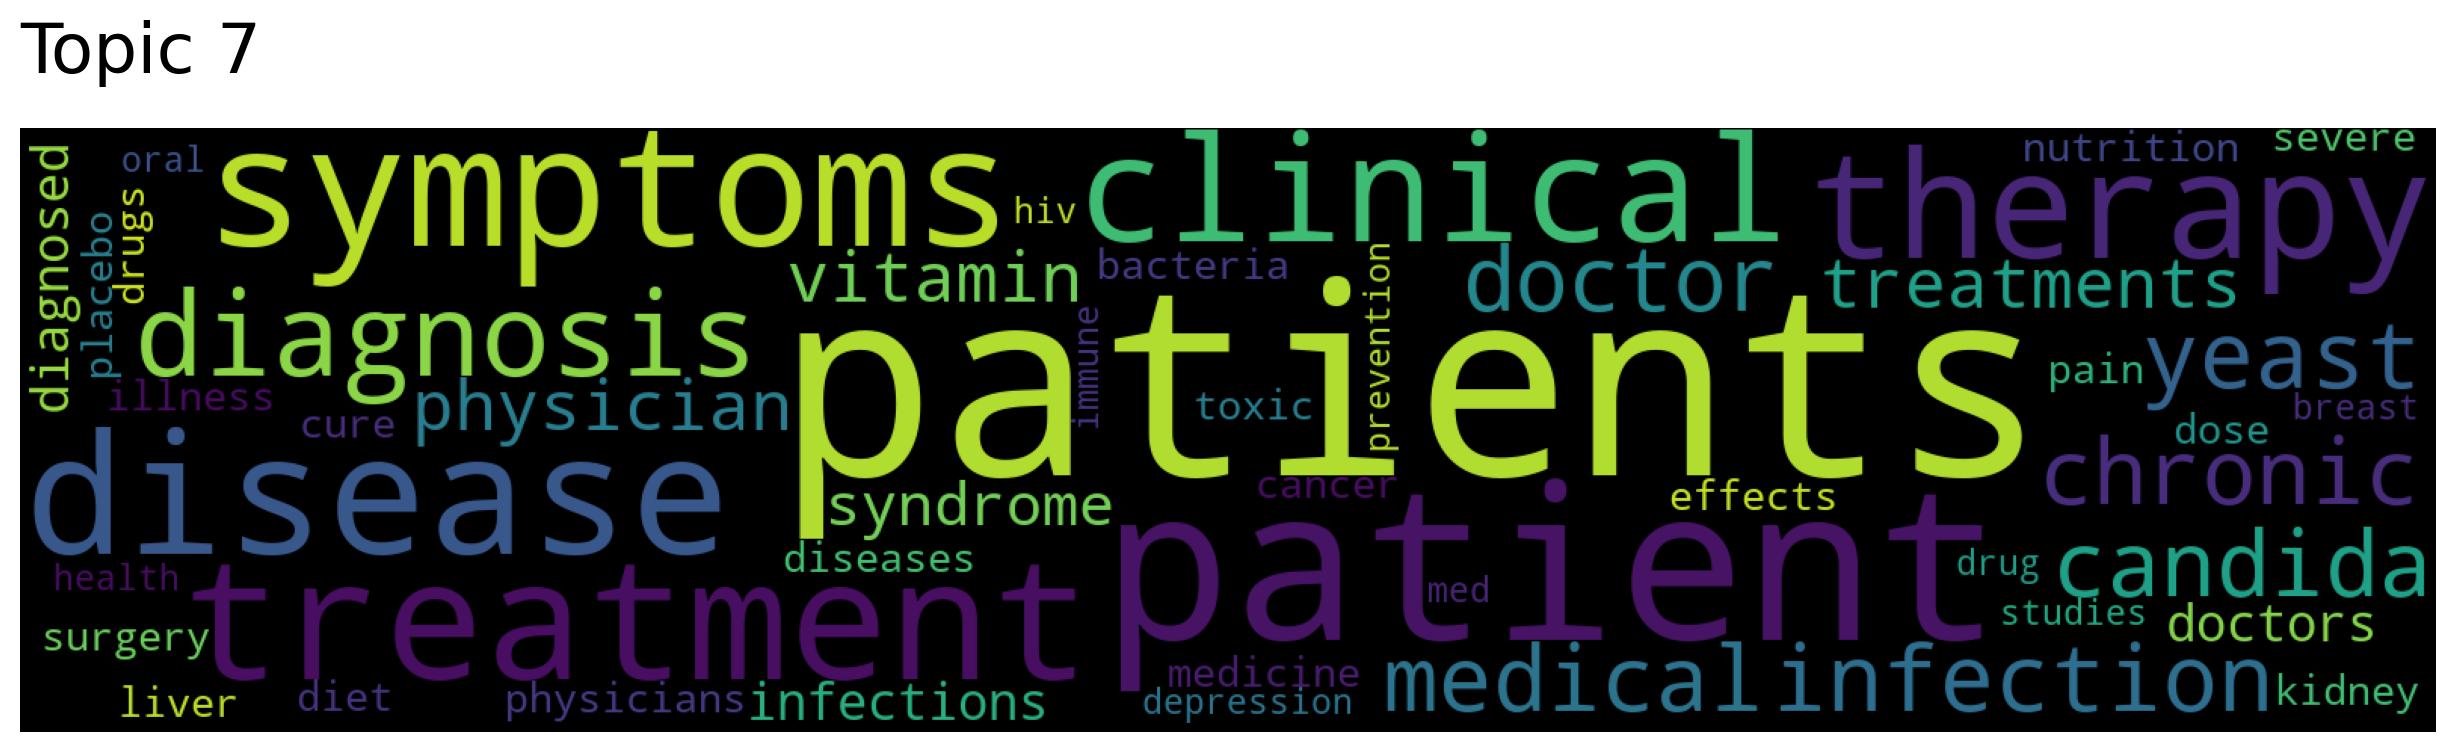

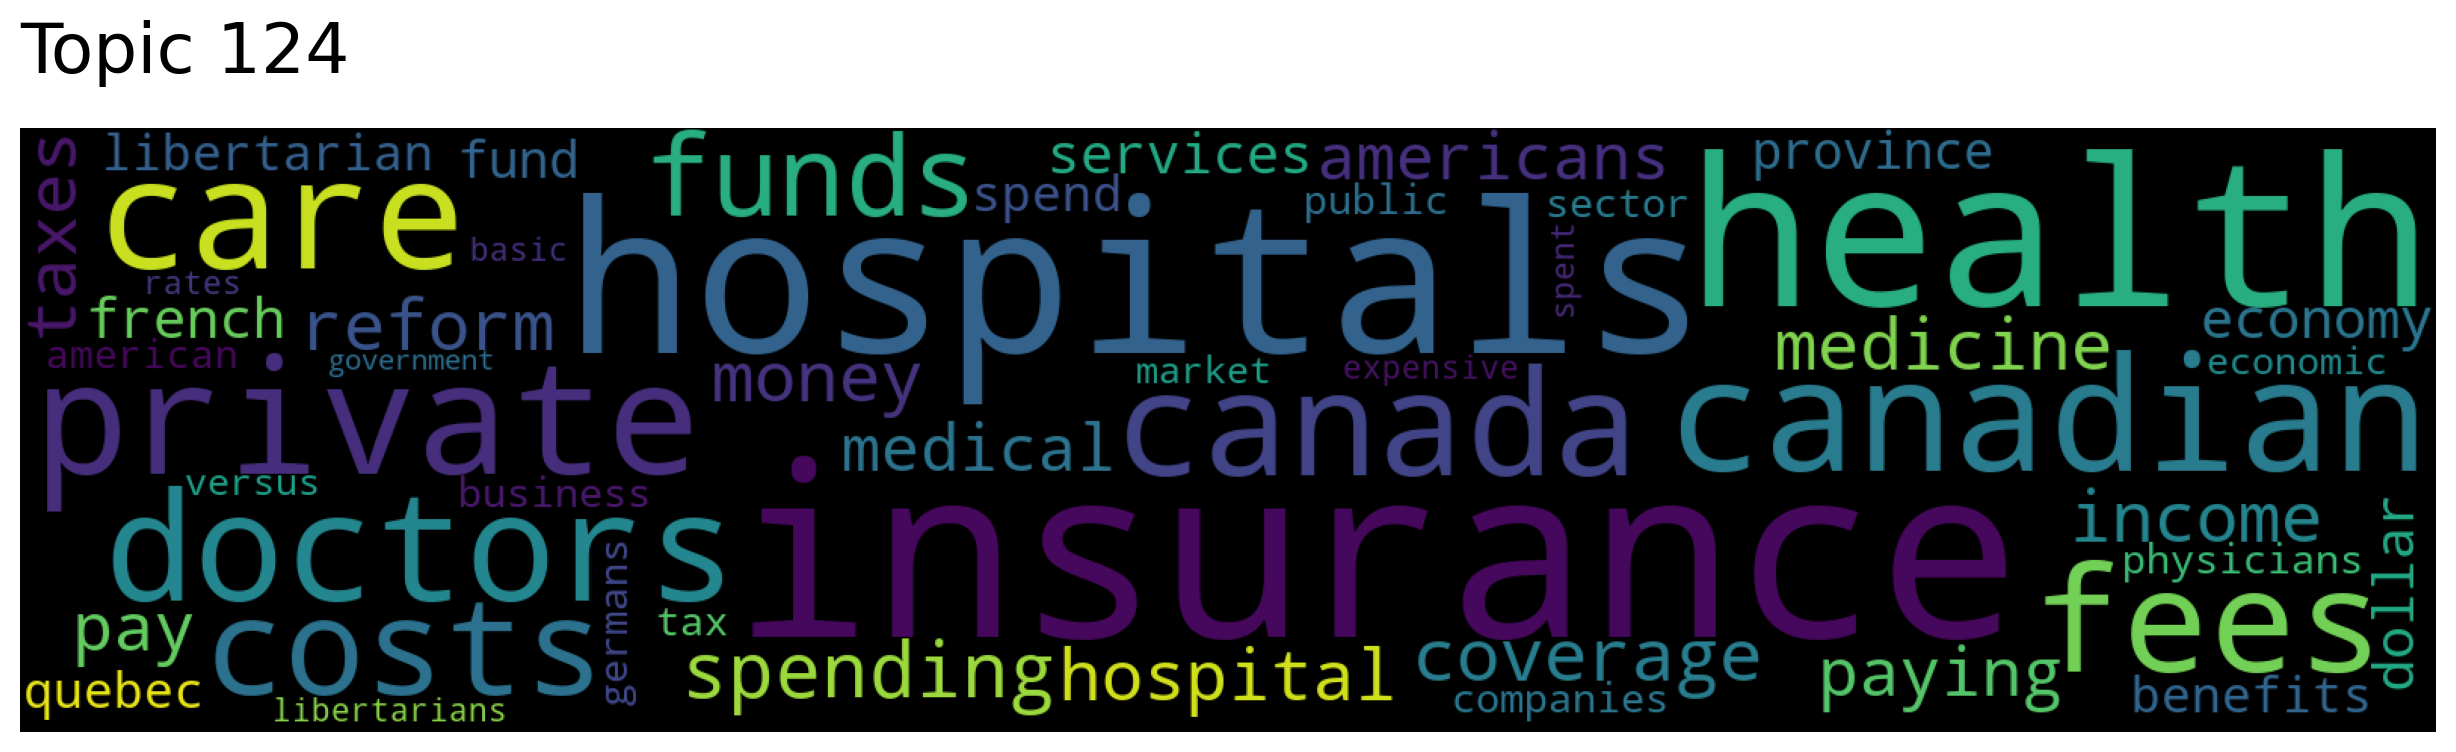

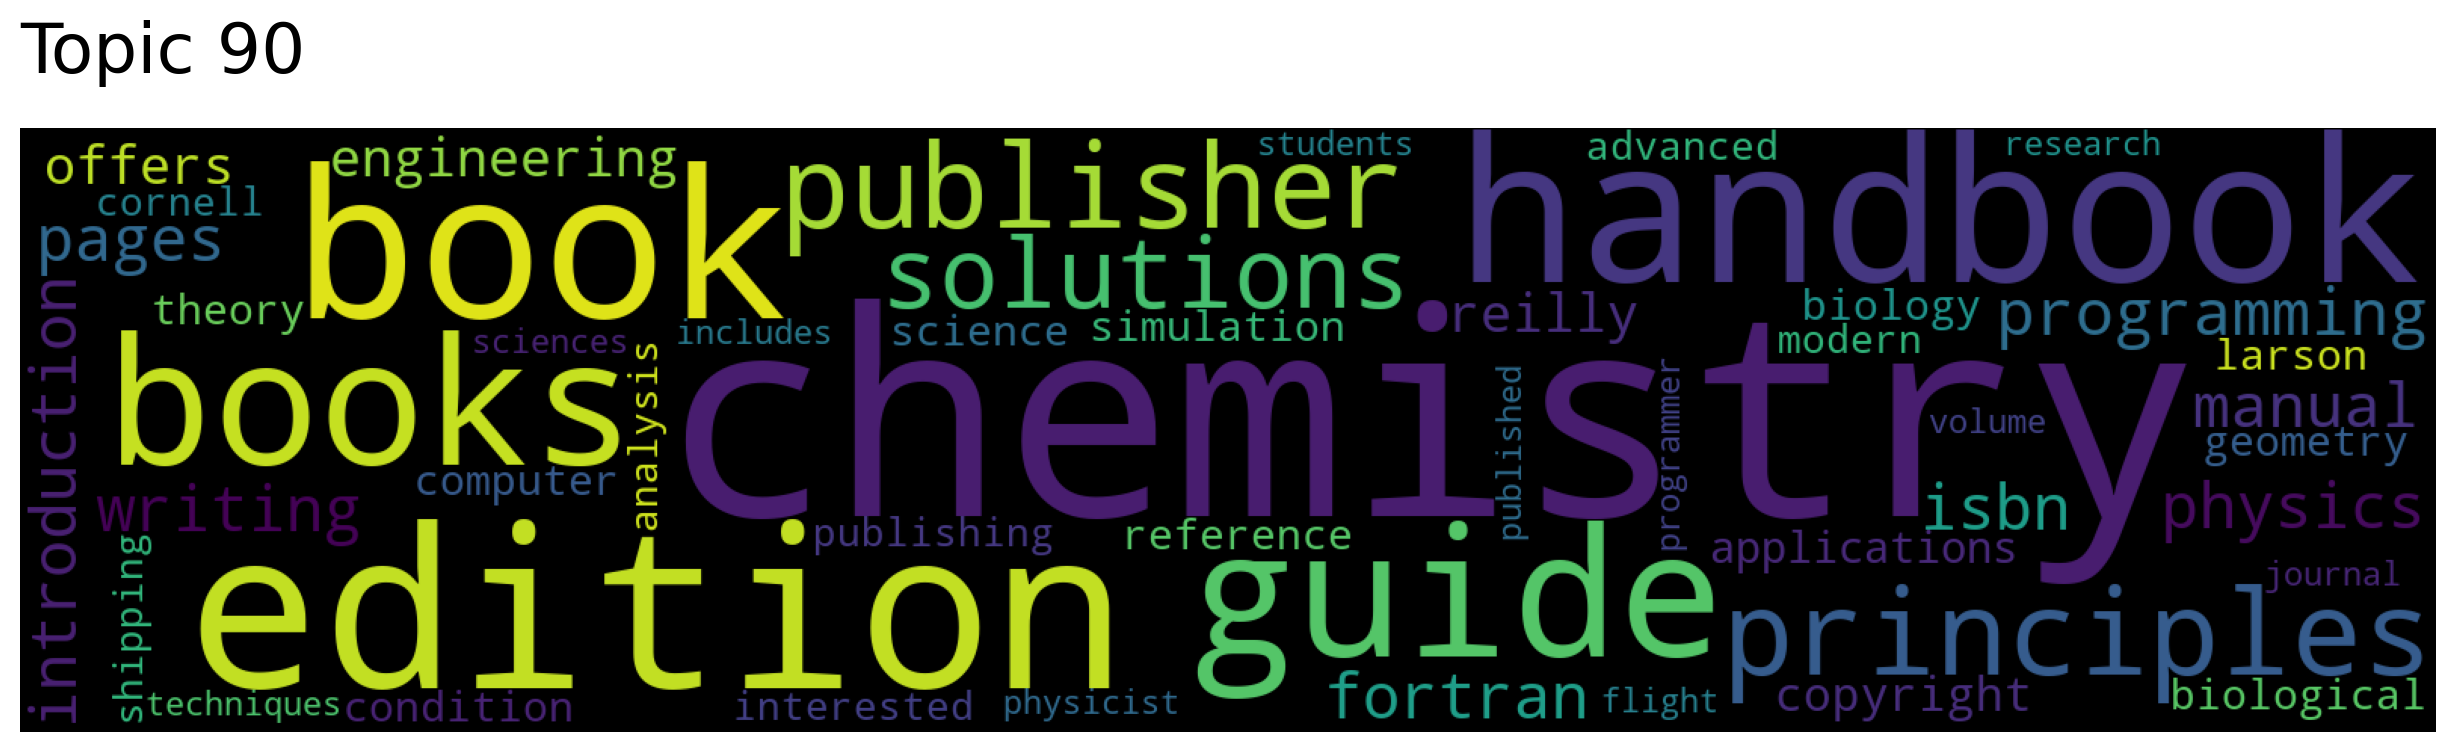

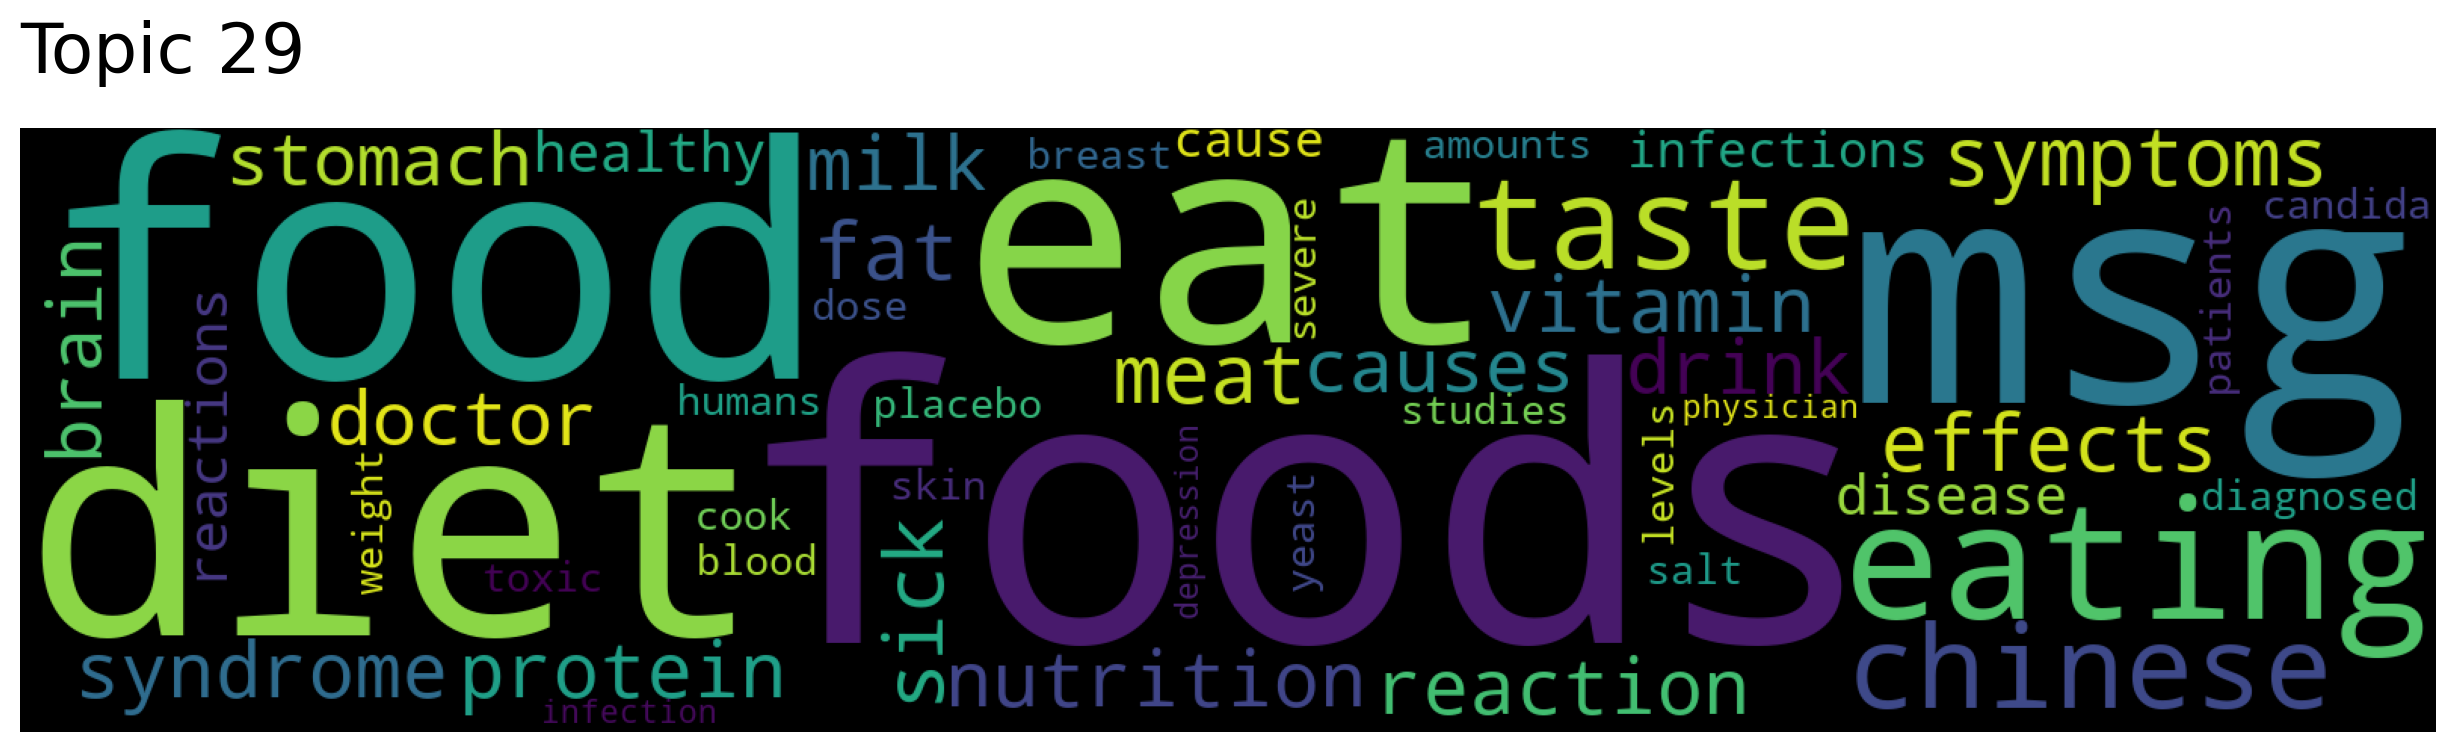

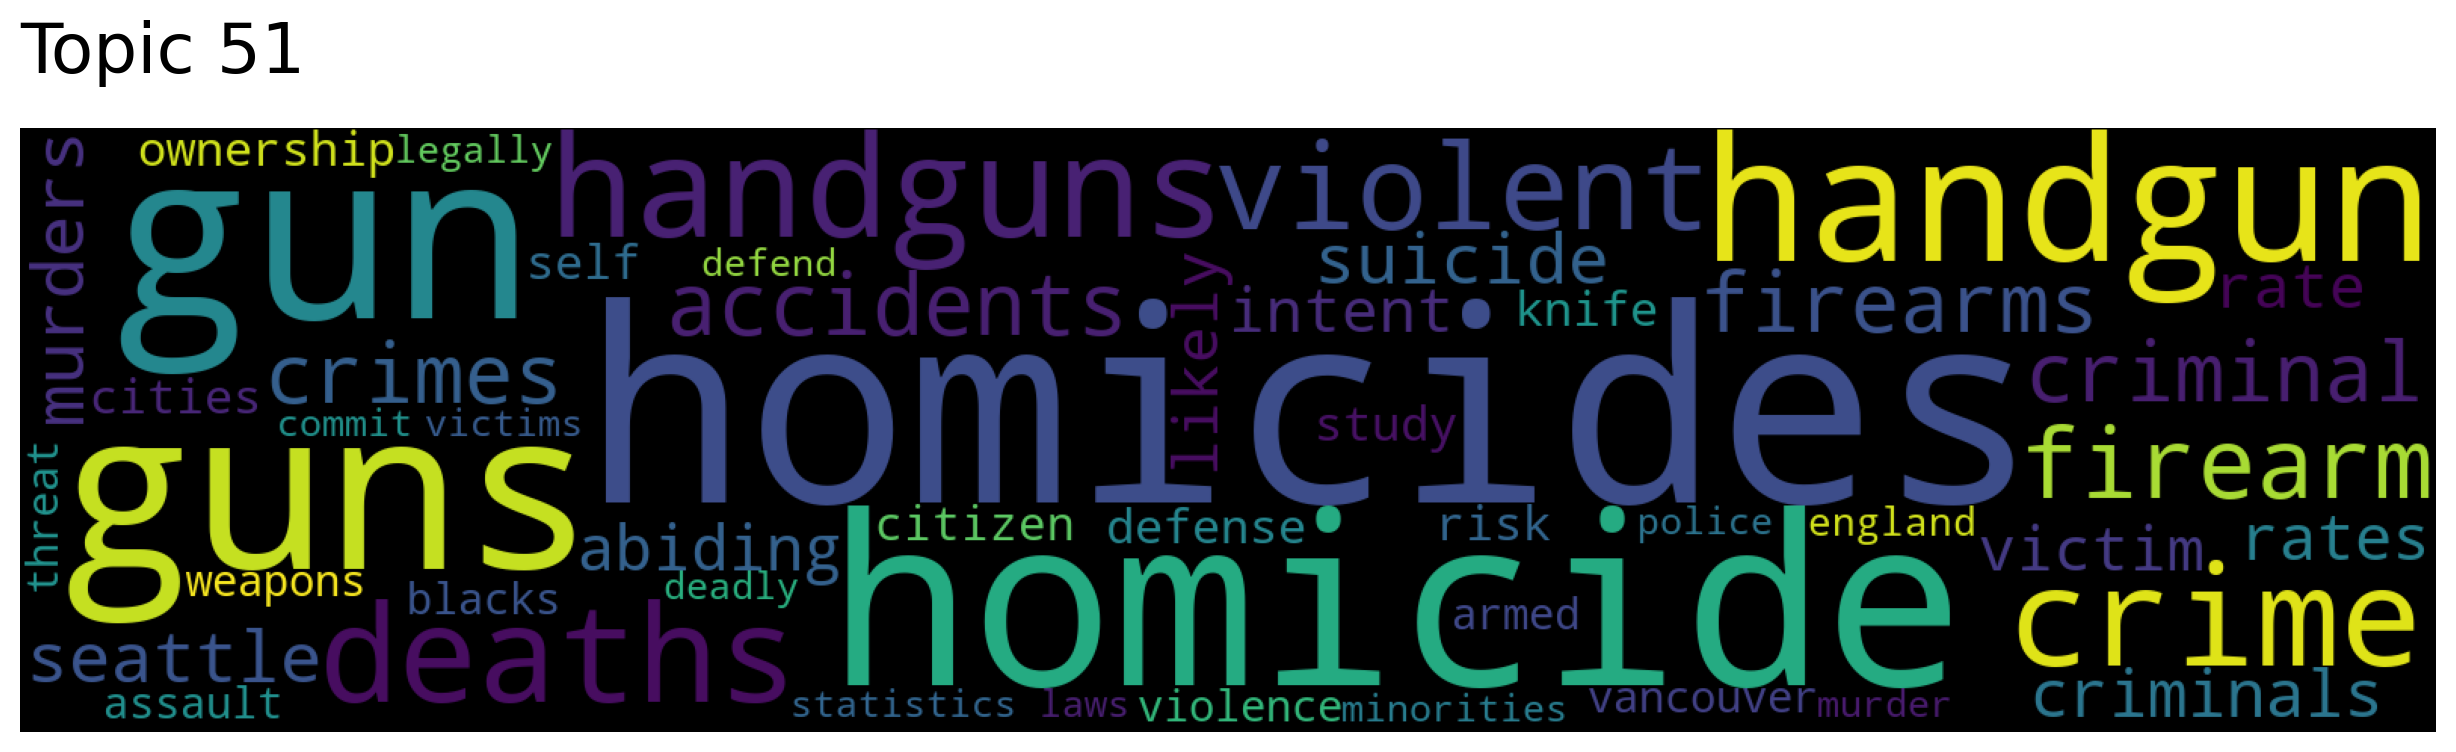

In [71]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["medicine"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [72]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=48, num_docs=5)

In [73]:
documents

array(['\nUsing the software you\'re using, I agree with you there.  What I did:\nI installed DOS, Windows and CPBackup (functionally the same\nas your Norton, for the purposes of this discussion), and used the \nDOS "backup" command on just that much.  To restore, I boot to the \n"system" diskette, and use DOS "restore" to read in that much, then\nboot to windows and restore my full backups using CPB (Norton, in your\ncase), overwriting what I\'ve just restored.  That allows me to keep\nthis skeletal Windows essentially unchanged, with all my customization\non the "real" copy done using the 3rd-party backup utility.\n\n\nSeems possible, if you can put skeletal versions of DOS and your backup\nutility on a "system" floppy.  Then you could restore it all on one "go".\n',
       'In the newer versions of Norton Backup for Windows (2.0 at least)\nthere is an "emergency" disk, which will allow you to restore\nfrom tape without reinstalling DOS/Windows (I understand it\'s sort\nof cumbersom

In [75]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=48, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 16776, Score: 0.7191997766494751
-----------

Using the software you're using, I agree with you there.  What I did:
I installed DOS, Windows and CPBackup (functionally the same
as your Norton, for the purposes of this discussion), and used the 
DOS "backup" command on just that much.  To restore, I boot to the 
"system" diskette, and use DOS "restore" to read in that much, then
boot to windows and restore my full backups using CPB (Norton, in your
case), overwriting what I've just restored.  That allows me to keep
this skeletal Windows essentially unchanged, with all my customization
on the "real" copy done using the 3rd-party backup utility.


Seems possible, if you can put skeletal versions of DOS and your backup
utility on a "system" floppy.  Then you could restore it all on one "go".

-----------

Document: 11379, Score: 0.6766526699066162
-----------
In the newer versions of Norton Backup for Windows (2.0 at least)
there is an "emergency" disk, which will allow you to re

In [76]:
words, word_scores = model.similar_words(keywords=["space"], keywords_neg=[], num_words=20)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

nasa 0.6567
shuttle 0.6281
launch 0.5567
planetary 0.5533
exploration 0.5306
satellite 0.5232
orbital 0.5079
telescope 0.4945
solar 0.4891
missions 0.4809
ames 0.4799
astronomy 0.4724
station 0.4656
spacecraft 0.4621
satellites 0.4615
orbit 0.461
orbiting 0.4602
astro 0.4598
technical 0.4597
development 0.4555
